### Rotations on the Poincaré sphere and abitrary polarization state correction
Relevant for FORT polarization optimization in the network experiment.

In [60]:
import numpy as np
from numpy.random import rand
from numpy import sin, cos, exp, pi, sqrt, trace, dot, vdot
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## definitions

In [122]:
# states defined in the basis {1,0} = {H,V}
V = np.array([0,1])
H = np.array([1,0])
D = np.array([1,1])/sqrt(2)
A = np.array([1,-1])/sqrt(2)
R = np.array([1,-1j])/sqrt(2)
L = np.array([1,1j])/sqrt(2)

# in the H,V basis
s0 = np.array([[1,0],[0,1]])
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

# we want to switch to the R,L basis, which is more common for drawing on the Poincaré sphere
projR = np.outer(R,np.conj(R))
evals, evecs = np.linalg.eig(projR)
U = evecs.transpose() # doesn't do anything in this case b.c. the matrix is symmetric about the diagonal
# U[:,[1,0]] = U[:,[0,1]] # I found it necessary to swap the columns
Uinv = np.linalg.inv(U)
assert np.isclose(trace(Uinv.dot(projR).dot(U)), np.sum(Uinv.dot(projR).dot(U))), "oops, matrix isn't diagonal" 

# in the R,L basis
s1 = Uinv.dot(s1).dot(U)
s2 = Uinv.dot(s2).dot(U)
s3 = Uinv.dot(s3).dot(U)

def poincare_sphere(ax=None):
    """
    plots the Poincare sphere and returns the associated Axes object ax.

    The Z axis is vertical, as is standard, with circular polarization at the Z poles, H/V along X, and D/A along Y.

    ax: an Axes object. if not provided, one will be created
    """
    
    # Create a sphere
    phi, theta = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    if ax is None:
        fig = plt.figure(figsize=(5, 5),dpi=100)
        ax = fig.add_subplot(111, projection='3d')
    
    # Plotting the Poincaré sphere    
    ax.plot_surface(x, y, z, color='pink', alpha=0.3, rstride=1, cstride=1, linewidth=0)
    
    # Labeling the poles
    ax.text(0, 0, 1.1, 'R', color='black', fontsize=14, ha='center')
    ax.text(0, 0, -1.1, 'L', color='black', fontsize=14, ha='center')
    
    ax.text(1.1, 0, 0, 'V', color='black', fontsize=14, ha='center')
    ax.text(-1.1, 0, 0, 'H', color='black', fontsize=14, ha='center')
    
    ax.text(0, 1.1, 0, 'D', color='black', fontsize=14, ha='center')
    ax.text(0, -1.1, 0, 'A', color='black', fontsize=14, ha='center')
    
    # Generate points for the equatorial circle
    theta = np.linspace(0, 2 * np.pi, 100)
    x_eq = np.cos(theta)
    y_eq = np.sin(theta)
    z_eq = np.zeros_like(theta)
    
    # Plot the equatorial circle
    ax.plot(x_eq, y_eq, z_eq, 'k--')  # 'k--' specifies a black dashed line
    
    axis_pts = np.linspace(-1, 1, 100)
    ax.plot(axis_pts, np.zeros_like(axis_pts), np.zeros_like(axis_pts), 'k--')
    ax.plot(np.zeros_like(axis_pts), axis_pts, np.zeros_like(axis_pts), 'k--')
    ax.plot(np.zeros_like(axis_pts), np.zeros_like(axis_pts), axis_pts, 'k--')
    
    # Setting the aspect ratio
    ax.set_box_aspect([1,1,1])
    
    # Hide the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Transparent spines
    ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    
    # Transparent panes
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_aspect('equal')
    
    return ax

def get_stokes_params(jones_vec):
    """
    compute the four Stokes parameters from a 2-element Jones vector
    """
    rho = np.outer(np.conj(jones_vec),jones_vec)
    S0 = trace(dot(s0,rho))
    S1 = trace(dot(s1,rho))
    S2 = trace(dot(s2,rho))
    S3 = trace(dot(s3,rho))
    
    return np.real(S0), np.real(S1), np.real(S2), np.real(S3)

def draw_stokes_vector(ax, jones_vec, color='k', label=''):
    """
    plot the 2-element complex jones vector on the supplied ax
    
    ax is presumed to be a 3D projection. 

    Note that the Stokes parameters S3, S2, and S1 used here are with respect to a basis {1,0} = {R,L}, which are
    are typically taken to be at the poles of, e.g. the Bloch sphere, or equivalently, along the S3 axis of the Poincare sphere. 
    However, unlike the typical convention, {H,V} is taken to be along S2 (Y) and {D,A} along S1 (X), which is unlike
    the typical convention. I did this because I found that those were the components of the respective states after transforming
    the Pauli matrices to the R,L basis. 
    
    return S0, S1, S2, S3
    """

    S0, S1, S2, S3 = get_stokes_params(jones_vec)
    
    ax.text(1.2*S2, 1.2*S1, 1.2*S3, label, color=color, fontsize=14, ha='center')
    ax.quiver(0, 0, 0, S2, S1, S3, color=color, arrow_length_ratio=0.1)

QWP = lambda theta: np.array([[(0.5-0.5*1j)*(1j + cos(2*theta)),(1j-1)*cos(theta)*sin(theta)],
                              [(1j-1)*cos(theta)*sin(theta), 1j*cos(theta)**2+sin(theta)**2]])

HWP = lambda theta: np.array([[cos(2*theta), -2*cos(theta)*sin(theta)],
                              [-2*cos(theta)*sin(theta), -cos(2*theta)]])

# arbitrarty-wave plate: can be any unitary transformation
AWP = lambda theta, phi, eta: exp(-1j*eta/2)*np.array([[cos(theta)**2+exp(1j*eta)*sin(theta)**2, (1-exp(1j*eta))*exp(-1j*phi)*cos(theta)*sin(theta)],
                                                       [(1-exp(1j*eta))*exp(1j*phi)*cos(theta)*sin(theta), exp(1j*eta)*cos(theta)**2+sin(theta)**2]])

## waveplate rotations on Poincaré sphere

## polarization after an arbitrary waveplate (e.g. an SM fiber)
This section is relevant for optimizing the polarization of the FORT

In [105]:
# check that the arbitrary waveplate matrix does not change the length of the state vector - should print nothing if the test passes
for chi in [V,H,D,A,R,L]:
    for trial in range(1000):
        stokes_params = get_stokes_params(dot(AWP(2*pi*rand(), 2*pi*rand(), 2*pi*rand()), chi))
        stokes_123 = stokes_params[1:]
        assert np.isclose(dot(stokes_123,stokes_123),1), "oops, the Stokes vector length has not been preserved (no longer a pure state, or an error)"

In the network experiment, we have a linear state of light which passes through a quarter waveplate, half waveplate, SM fiber, and finally a polarizer, after which we can record the power. Technically, the power is not well controlled, but if the drift is slow (~ constant over an optimization run), we can ignore it. For now, we will ignore this, though we can add in some drift later to see the effect.

In [124]:
# check that for any arbitrary waveplate, we can always find a qwp,hwp combo to make the state V at the end

chi0 = V # the initial state

# meshgrid doesn't play nicely with matrix algebra so let's just for loop it
pts = 100
angles = np.linspace(-pi/4, pi/4, 100)
failed_angles = []
PV_max_failures = [] 
for trial in range(100):
    PV_array = np.zeros((pts, pts)) # array of the probability of measuring V for each pair of quarter and half waveplate angles
    rand_eta = 2*pi*rand()
    rand_phi = 2*pi*rand()
    rand_theta = 2*pi*rand()
    awp = AWP(rand_theta, rand_phi, rand_eta) # initialize a random waveplate.
    for i,theta in enumerate(angles):
        for j,phi in enumerate(angles):

            # # check the Stokes params from only applying the AWP (just a sanity check)
            # stokes_params = get_stokes_params(dot(awp, chi0))
            # stokes_123 = stokes_params[1:]
            # assert np.isclose(dot(stokes_123,stokes_123),1), "oops, the Stokes vector length has not been preserved - AWP did it"

            # # check the Stokes params from only applying the QWP and HWP (just a sanity check)
            # stokes_params = get_stokes_params(dot(QWP(phi).dot(HWP(theta)), chi0))
            # stokes_123 = stokes_params[1:]
            # assert np.isclose(dot(stokes_123,stokes_123),1), "oops, the Stokes vector length has not been preserved - QWP or HWP did it"

            # project the state after the arb. w.p., qwp, and hwp onto V. should never exceed V, but could be less than
            # arbitrary waveplate comes last, just like the SM fiber comes after the QWP and HWP in the experiment.
            PV_array[i,j] = abs(dot(V,awp.dot(QWP(phi)).dot(HWP(theta)).dot(chi0)))**2
            
    PV_max = np.amax(PV_array)
    if not np.isclose(PV_max,1,atol=1e-3): # check that for at least one pair of waveplate angles, we were able to P(V) = 1
        failed_angles.append([rand_theta,rand_phi,rand_eta])
        PV_max_failures.append(PV_max)
if not len(failed_angles) > 0:
    print("success! we could always correct for the fiber birefringence")
else:
    print("we couldn't always compensate the polarization error induced by the fiber!")

success! we could always correct for the fiber birefringence


## testing

In [4]:
HWP(0), HWP(pi/4), QWP(0), QWP(-pi/4)

(array([[ 1.,  0.],
        [ 0., -1.]]),
 array([[ 6.123234e-17,  1.000000e+00],
        [ 1.000000e+00, -6.123234e-17]]),
 array([[1.000000e+00+0.j, 0.000000e+00+0.j],
        [0.000000e+00+0.j, 6.123234e-17-1.j]]),
 array([[ 1.+0.0000000e+00j, -0.-1.0000000e+00j],
        [-0.-1.0000000e+00j, -1.-1.2246468e-16j]]))

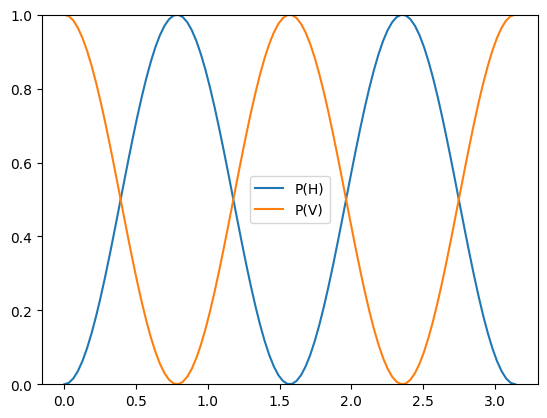

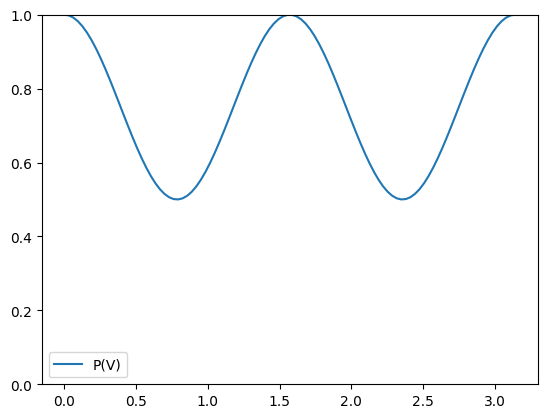

In [56]:
t_pts = np.linspace(0,pi,100)
plt.plot(t_pts, [abs(dot(HWP(t),V))**2 for t in t_pts], label=['P(H)','P(V)'])
plt.ylim((0,1))
plt.legend()
plt.show()

plt.plot(t_pts, [abs(dot(QWP(t),V).dot(V))**2 for t in t_pts], label='P(V)')
plt.legend()
plt.ylim((0,1))
plt.show()

In [38]:
angles = np.linspace(-pi/4, pi/4, 100)
theta_mesh, phi_mesh = np.meshgrid(angles, angles)

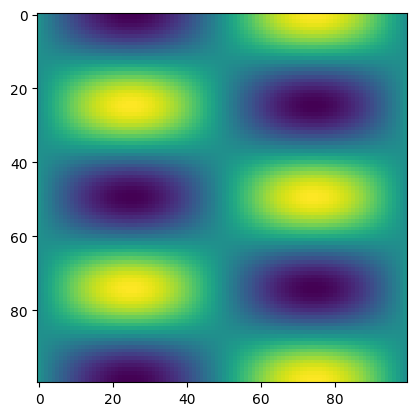

In [45]:
surface = lambda t,p: sin(4*t)*cos(8*p)
plt.imshow(surface(theta_mesh, phi_mesh))

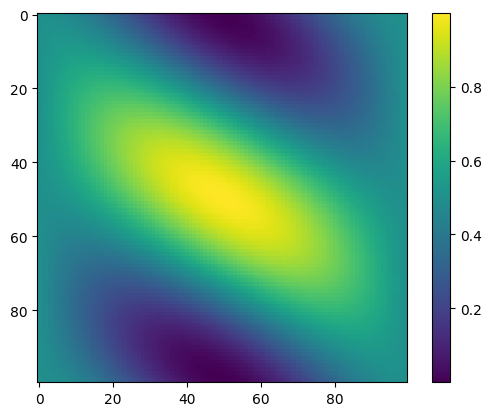

In [87]:
# meshgrid doesn't play nicely with matrix algebra so let's just for loop it
pts = 100
angles = np.linspace(-pi/4, pi/4, 100)
PV_array = np.zeros((pts, pts))
for i,theta in enumerate(angles):
    for j,phi in enumerate(angles):
        PV_array[i,j] = abs(vdot(V,QWP(phi).dot(HWP(theta)).dot(V)))**2
plt.imshow(PV_array)
plt.colorbar()

In [66]:
hwp_mesh = HWP(theta_mesh)
qwp_mesh = QWP(phi_mesh)

# chi = lambda mesh: V # stupid way to augment the dimensionality of the state vector
# chi_mesh = chi(theta_mesh)
# surface = lambda t,p: abs(V.dot(dot(HWP(t),QWP(p)).dot(V)))**2
# plt.imshow(surface(theta_mesh, phi_mesh))

# PV_map = abs(dot(HWP(theta_mesh),dot(QWP(phi_mesh),V)).dot(V))**2



In [72]:
chi_mesh = np.zeros(hwp_mesh.shape[1:])

In [74]:
chi_mesh[:2,:,:] = V

ValueError: could not broadcast input array from shape (2,) into shape (2,100,100)

In [65]:
operator_mesh = dot(hwp_mesh, qwp_mesh)

In [67]:
diditwork = dot(operator_mesh, chi_mesh)

ValueError: shapes (2,2,100,2,2,100) and (2,) not aligned: 100 (dim 5) != 2 (dim 0)

In [64]:
plt.imshow(vdot(V,dot(operator_mesh,V)))

ValueError: shapes (2,2,100,2,2,100) and (2,) not aligned: 100 (dim 5) != 2 (dim 0)

In [77]:
xx = np.zeros((2,5,5))
xx

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])

In [79]:
theta_mesh.shape, hwp_mesh.shape, operator_mesh.shape

((100, 100), (2, 2, 100, 100), (2, 2, 100, 2, 2, 100))

In [84]:
np.einsum('i...,ij,...j',HWP(theta_mesh),QWP(phi_mesh)).shape

ValueError: more operands provided to einstein sum function than specified in the subscripts string

In [82]:
plt.imshow()

ValueError: shapes (2,2,100,2,2,100) and (2,) not aligned: 100 (dim 5) != 2 (dim 0)

In [ ]:
[dot(HWP(X),QWP(Y)) for X,Y in ]

In [214]:
dot(QWP(0),V), dot(QWP(pi/4),V)

(array([0.000000e+00+0.j, 6.123234e-17-1.j]), array([0.+1.j, 1.+0.j]))

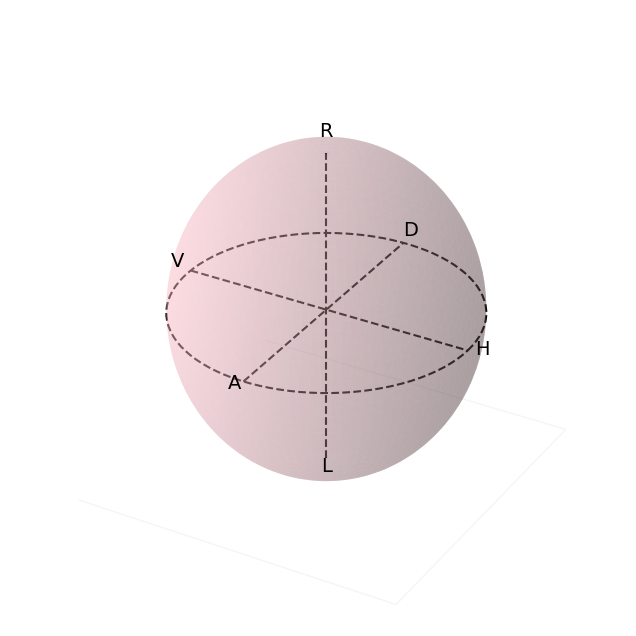

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = poincare_sphere()

ax.plot()

In [171]:
V = np.array([0,1])
H = np.array([1,0])
D = np.array([1,1])/sqrt(2)
A = np.array([1,-1])/sqrt(2)
R = np.array([1,-1j])/sqrt(2)
L = np.array([1,1j])/sqrt(2)

In [162]:
for u in [V,H,D,A,R,L]:
    print(np.dot(np.conj(u),u))

1
1
0.9999999999999998
0.9999999999999998
(0.9999999999999998+0j)
(0.9999999999999998+0j)


In [163]:
for u in [V,H,D,A,R,L]:
    print(np.outer(u,np.conj(u)))

[[0 0]
 [0 1]]
[[1 0]
 [0 0]]
[[0.5 0.5]
 [0.5 0.5]]
[[ 0.5 -0.5]
 [-0.5  0.5]]
[[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]
[[ 0.5+0.j  -0. +0.5j]
 [-0. -0.5j  0.5+0.j ]]


In [175]:
projR = np.outer(R,np.conj(R))
print(projR)

evals, evecs = np.linalg.eig(projR)
print(evecs)

U = evecs.transpose()
U[:,[1,0]] = U[:,[0,1]]
Uinv = np.linalg.inv(U)
Uinv.dot(projR).dot(U)

[[ 0.5+0.j  -0. +0.5j]
 [-0. -0.5j  0.5+0.j ]]
[[-0.        +0.70710678j  0.70710678+0.j        ]
 [ 0.70710678+0.j         -0.        +0.70710678j]]


array([[3.08839715e-32+0.00000000e+00j, 0.00000000e+00+2.68031548e-16j],
       [0.00000000e+00-1.67155782e-16j, 1.00000000e+00+0.00000000e+00j]])

V: S0=1, S1=1.0146536357569526e-17j, S2=(-1+0j), S3=(-3.133961632045815e-16+0j)
H: S0=1, S1=6.835808657661918e-17j, S2=(1+0j), S3=(3.8920038715097833e-16+0j)
D: S0=0.9999999999999998, S1=(0.9999999999999998+3.925231146709435e-17j), S2=-5.686135072515376e-17j, S3=(3.790211197319839e-17+0j)
A: S0=0.9999999999999998, S1=(-0.9999999999999998+3.925231146709435e-17j), S2=5.686135072515376e-17j, S3=(3.790211197319839e-17+0j)
R: S0=(0.9999999999999998+0j), S1=1.1102230246251565e-16j, S2=(3.885780586188048e-16+0j), S3=(-0.9999999999999997+0j)
L: S0=(0.9999999999999998+0j), S1=0j, S2=(-3.3306690738754696e-16+0j), S3=(0.9999999999999998+0j)


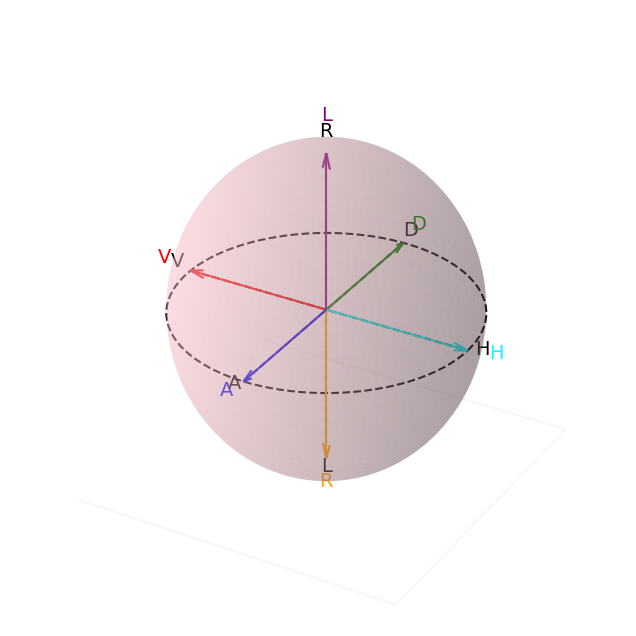

In [180]:
# in the H,V basis
s0 = np.array([[1,0],[0,1]])
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

# in the R,L basis
s1 = Uinv.dot(s1).dot(U)
s2 = Uinv.dot(s2).dot(U)
s3 = Uinv.dot(s3).dot(U)

ax = poincare_sphere()

for u, color, lbl in zip([V,H,D,A,R,L], ['red','cyan','green','blue','orange','purple'], ['V','H','D','A','R','L']):
    # rho = np.outer(u,np.conj(u))
    # S0 = trace(dot(s0,rho))
    # S1 = trace(dot(s1,rho))
    # S2 = trace(dot(s2,rho))
    # S3 = trace(dot(s3,rho))
    
    # print(f"{lbl}: S0={np.real(S0):.2f}, S1={np.real(S1):.2f}, S2={np.real(S2):.2f}, S3={np.real(S3):.2f}")

    # print(sqrt(S1**2+S2**2+S3**2)/S0**2)
    
    # ax.text(1.2*S1, 1.2*S2, 1.2*S3, lbl, color=color, fontsize=14, ha='center')
    # ax.quiver(0, 0, 0, S1, S2, S3, color=color, arrow_length_ratio=0.1)

    draw_stokes_vector(ax, u, color=color, label=lbl)

In [151]:
u = V
rho = np.outer(np.conj(u),u)
trace(dot(s1,rho))

-1.0146536357569551e-17j

In [63]:
dot(s1,rho)

array([[0, 1],
       [0, 0]])

In [65]:
s1 = np.outer(np.conj(D),D)
s2 = np.outer(np.conj(R),R)
s3 = np.outer(np.conj(H),H)

s1, s2, s3

(array([[0.5, 0.5],
        [0.5, 0.5]]),
 array([[ 0.5+0.j , -0. -0.5j],
        [-0. +0.5j,  0.5+0.j ]]),
 array([[1, 0],
        [0, 0]]))